In [20]:
from escnn import nn, gspaces
import matplotlib.pyplot as plt
import numpy as np
import torch

In [23]:
@torch.inference_mode()
def distance_torch(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    x = x.flatten(1); y = y.flatten(1)
    diff  = torch.linalg.vector_norm(x - y, dim=1)
    denom = torch.maximum(torch.linalg.vector_norm(x, dim=1),
                          torch.linalg.vector_norm(y, dim=1))
    denom = torch.where(denom > 0, denom, torch.ones_like(denom))
    return diff/denom
@torch.inference_mode()
def check_equivariance_batch(x_geo, model, group, num_samples=64):
    """
    Vectorized equivariance test: f(g·x) ?= g·f(x)
    Batches over rotations by stacking along the **batch** dim.
    """
    # sample elements
    thetas = np.linspace(0, 2*np.pi, num_samples, endpoint=True)
    elems  = [group.fibergroup.element(float(t)) for t in thetas]

    # stack rotated inputs along batch dimension
    xs = [x_geo.transform(g) for g in elems]  # list of GeometricTensor
    xb_tensor = torch.cat([gt.tensor for gt in xs], dim=0)          # (K*N, C, H, W)
    xb = nn.GeometricTensor(xb_tensor, x_geo.type)                 # preserve FieldType

    # single forward pass
    yb = model(xb)  # GeometricTensor, (K*N, C', H', W')

    # reference forward, then transform outputs and stack along batch
    y_ref = model(x_geo)                                            # (N, C', H', W')
    ys = [y_ref.transform(g) for g in elems]
    y_ref_b_tensor = torch.cat([gt.tensor for gt in ys], dim=0)     # (K*N, C', H', W')
    y_ref_b = nn.GeometricTensor(y_ref_b_tensor, y_ref.type)

    # per-sample relative error
    errs = distance_torch(yb.tensor, y_ref_b.tensor)                 # (K*N,)
    # average across original batch if N>1
    N = x_geo.tensor.shape[0]
    return thetas, errs.view(num_samples, N).mean(dim=1).cpu().numpy()


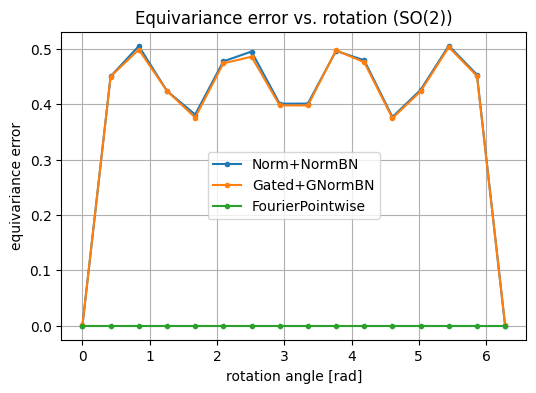

In [28]:
import torch, numpy as np, matplotlib.pyplot as plt
from escnn import gspaces, nn

# --- group & test sampler ---
r2_act = gspaces.rot2dOnR2(maximum_frequency=1)
num_samples = 16
thetas = np.linspace(0, 2*np.pi, num_samples, endpoint=True)
elements = [r2_act.fibergroup.element(theta) for theta in thetas]

g = gspaces.rot2dOnR2(N=-1)                   # SO(2)
G = g.fibergroup
ft_in = nn.FieldType(g, [g.trivial_repr])     # scalar input
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- model builders (same depth: conv -> act/norm -> bn -> conv) ---
def build_norm_normbn(C=8):
    ft = nn.FieldType(g, [g.irrep(0), g.irrep(1)]*C)      # pure nontrivial => NormBN valid
    return nn.SequentialModule(
        nn.R2Conv(ft_in, ft, 3, padding=1, bias=False),
        nn.NormNonLinearity(ft),
        nn.FieldNorm(ft, affine=True),
        nn.R2Conv(ft, ft, 3, padding=1, bias=False),
    )

def build_gated_gnormbn(C=8):
    feats = [g.irrep(0), g.irrep(1)]*C
    gates = [g.trivial_repr]*len(feats)
    ft_full = nn.FieldType(g, gates + feats)       # gates FIRST
    ft_feat = nn.FieldType(g, feats)  # for batchnorm
    len(ft_feat)
    return nn.SequentialModule(
        nn.R2Conv(ft_in, ft_full, 3, padding=1, bias=False),
        nn.GatedNonLinearity1(ft_full, drop_gates=True),
        nn.FieldNorm(ft_feat, affine=True),
        nn.R2Conv(ft_feat, ft_feat, 3, padding=1, bias=False),
    )

def build_tensorproduct_11_to_2(C=8):
    ft1 = nn.FieldType(g, [g.irrep(1)]*C)          # uniform in
    ft2 = nn.FieldType(g, [g.irrep(2)]*C)          # valid: 1⊗1 -> 2
    return nn.SequentialModule(
        nn.R2Conv(ft_in, ft1, 3, padding=1, bias=False),
        nn.TensorProductModule(ft1, ft2, initialize=True),
        nn.FieldNorm(ft2, affine=True),
        nn.R2Conv(ft2, ft1, 3, padding=1, bias=False),  # keep width comparable
    )

def build_fourier_pointwise(C=8, L=3, N=16):
    act = nn.FourierPointwise(g, channels=C, irreps=G.bl_irreps(L), N=N)
    ft = act.out_type
    return nn.SequentialModule(
        nn.R2Conv(ft_in, ft, 3, padding=1, bias=False),
        act,
        nn.FieldNorm(ft, affine=True),
        nn.R2Conv(ft, ft, 3, padding=1, bias=False),
    )

models = {
    "Norm+NormBN":        build_norm_normbn(8),
    "Gated+GNormBN":      build_gated_gnormbn(8),
    # "TensorProd(1x1→2)":  build_tensorproduct_11_to_2(8),
    "FourierPointwise":   build_fourier_pointwise(8, L=0, N=16),
}

# --- run equivariance tests ---
x = torch.randn(1, 1, 128, 128)
x = ft_in(x).to(device)

plt.figure(figsize=(6,4))
for name, model in models.items():
    model = model.to(device)
    thetas_out, errors = check_equivariance_batch(x, model, group=r2_act, num_samples=num_samples)
    plt.plot(thetas_out, errors, marker="o", ms=3, label=name)
plt.xlabel("rotation angle [rad]"); plt.ylabel("equivariance error")
plt.title("Equivariance error vs. rotation (SO(2))")
plt.legend(); plt.grid(True); plt.show()
